<a href="https://colab.research.google.com/github/muhammadrivan1234/Praktikum/blob/main/Tugas_13_VAE_AkmalNuurFauzan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama  : Akmal Nuur Fauzan\
Kelas : TI22A\
NIM   : 20220040060\
source : https://github.com/Snigdho8869/AI-Generative-Models-Notebooks-DCGAN-VAE-Autoencoder.git

Downloading and Preparing Anime Faces Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Colab_Notebooks/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat '/content/drive/MyDrive/Colab_Notebooks/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d soumikrakshit/anime-faces

Dataset URL: https://www.kaggle.com/datasets/soumikrakshit/anime-faces
License(s): unknown
anime-faces.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/anime-faces.zip

Archive:  /content/anime-faces.zip
replace data/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Importing the Necessaries Libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, LeakyReLU
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, AvgPool2D, UpSampling2D
from keras.layers import Activation, BatchNormalization, Add, Multiply
from keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [ ]:
data_path = '/content/data'
image_size = (64, 64)
batch_size = 32

latent_dim = 1024
num_epochs = 50

In [ ]:
def load_and_preprocess_data(data_path, image_size):
    datagen = ImageDataGenerator(rescale=1./255)
    data_generator = datagen.flow_from_directory(
        data_path,
        target_size=image_size,
        class_mode='input',
        shuffle=True
    )

    images, _ = next(data_generator)
    return images

images = load_and_preprocess_data(data_path, image_size)

Found 21551 images belonging to 1 classes.


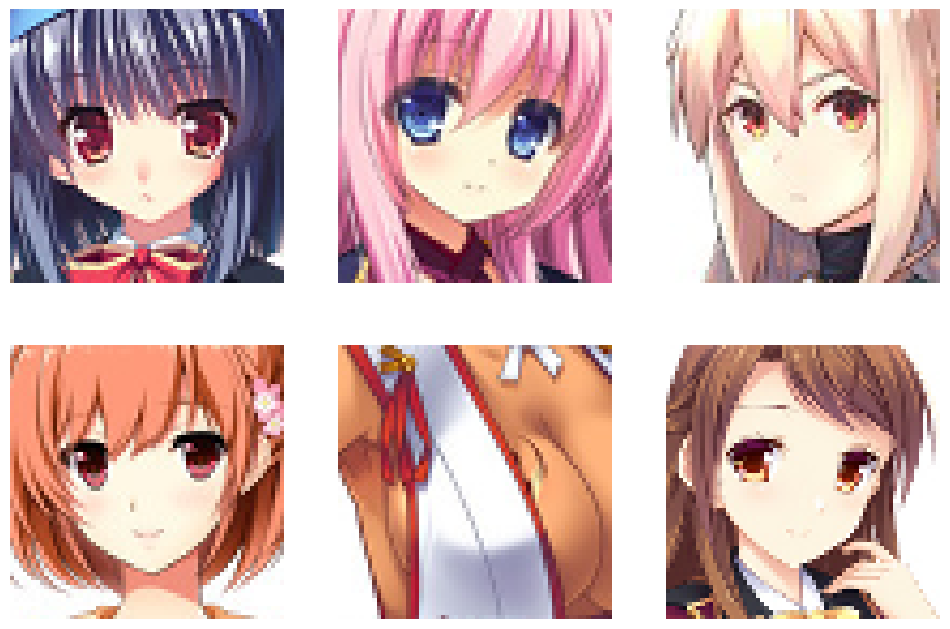

In [ ]:
def display_images(images):
    num_images = len(images)
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    for i in range(2):
        for j in range(3):
            if i*3 + j < num_images:
                axes[i, j].imshow(images[i*3 + j])
                axes[i, j].axis('off')

    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()

display_images(images[:6])

In [ ]:
def build_encoder(input_shape, latent_dim):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (1, 1), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (4, 4), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (4, 4), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dense(2 * latent_dim)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling)([z_mean, z_log_var])

    encoder_model = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder_model

encoder = build_encoder((64, 64, 3), latent_dim)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 32, 32, 64)           256       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_15 (Ba  (None, 32, 32, 64)           256       ['conv2d_8[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 leaky_re_lu_15 (LeakyReLU)  (None, 32, 32, 64)           0         ['batch_normalization_15

In [ ]:
def build_decoder(latent_dim):
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(4 * 4 * 512)(decoder_input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Reshape((4, 4, 512))(x)

    x = Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    outputs = Conv2DTranspose(3, (5, 5), padding='same', activation='sigmoid')(x)

    decoder_model = Model(decoder_input, outputs, name='decoder')
    return decoder_model

decoder = build_decoder(latent_dim)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_10 (Dense)            (None, 8192)              8396800   
                                                                 
 batch_normalization_20 (Ba  (None, 8192)              32768     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 8, 8, 256)         3277056   
 Transpose)                                                

In [ ]:
vae_input = Input(shape=(64, 64, 3))
vae_output = decoder(encoder(vae_input)[2])
vae = Model(vae_input, vae_output, name='vae')

vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 encoder (Functional)        [(None, 1024),            23741312  
                              (None, 1024),                      
                              (None, 1024)]                      
                                                                 
 decoder (Functional)        (None, 64, 64, 3)         12840131  
                                                                 
Total params: 36581443 (139.55 MB)
Trainable params: 36558019 (139.46 MB)
Non-trainable params: 23424 (91.50 KB)
_________________________________________________________________


In [ ]:
def vae_loss(inputs, outputs):
    reconstruction_loss = tf.reduce_mean(tf.square(inputs - outputs))
    return reconstruction_loss

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        n = 10
        random_images = images[np.random.choice(images.shape[0], n, replace=False)]
        reconstructed_images = vae.predict(random_images)

        plt.figure(figsize=(20, 4))
        for i in range(n):
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(random_images[i])
            plt.axis('off')

            ax = plt.subplot(2, n, i + n + 1)
            plt.imshow(reconstructed_images[i])
            plt.axis('off')

        plt.show()

Training around minimum 10 times

In [ ]:
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

vae.compile(optimizer=optimizer, loss=vae_loss, metrics=[ssim_metric, psnr_metric])

vae.fit(images, images, epochs=50, batch_size=batch_size, callbacks=[CustomCallback()])

1/1 [==============================] - 0s 229ms/step


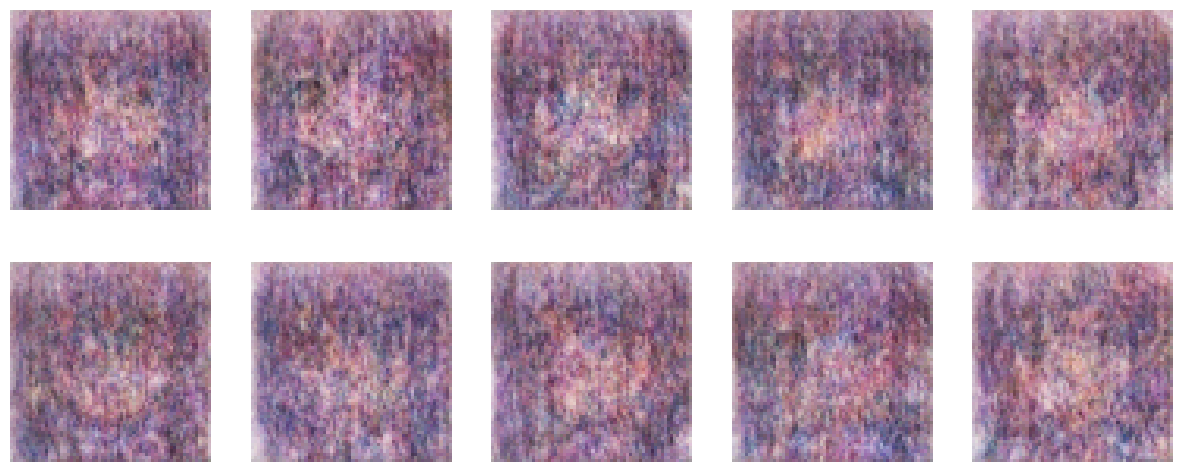

In [ ]:
def generate_anime_faces(num_faces=10):
    random_latent_vectors = np.random.normal(size=(num_faces, latent_dim))
    generated_images = decoder.predict(random_latent_vectors)

    plt.figure(figsize=(15, 6))
    for i in range(num_faces):
        ax = plt.subplot(2, num_faces // 2, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

generate_anime_faces()

In [ ]:
vae.save('/content/vae_model.h5')
encoder.save('/content/encoder_model.h5')
decoder.save('/content/decoder_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
